In [1]:
import os, pickle
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.stimulus_info import BrainObservatoryMonitor

In [3]:
DATA_DIR = 'BrainObservatoryData'
MANIFEST_FILE = os.path.join(DATA_DIR, 'manifest.json')
boc = BrainObservatoryCache(manifest_file=MANIFEST_FILE)

In [4]:
session_dict = {'locally_sparse_noise': 'three_session_C', 
                'natural_scenes':       'three_session_B',
                'natural_movie_one':    'three_session_A',
                'natural_movie_two':    'three_session_C',
                'natural_movie_three':  'three_session_A',
                'drifting_gratings':    'three_session_A',
                'static_gratings':      'three_session_B'}

def get_stimulus_template(stimulus_type):
    session_type = session_dict[stimulus_type]

    experiment_id = boc.get_ophys_experiments(session_types=[session_type])[0]['id']
    experiment = boc.get_ophys_experiment_data(experiment_id)

    stimulus_template = experiment.get_stimulus_template(stimulus_type)
    return stimulus_template

In [5]:
from allensdk.brain_observatory.stimulus_info import make_display_mask
from skimage.transform import resize

def get_image_stimulus(stimulus_type='natural_scenes', new_size=(256,256)):
    
    Y, X = np.where(make_display_mask().T)
    YMIN, YMAX = np.min(Y), np.max(Y)
    XMIN, XMAX = np.min(X), np.max(X)

    stimulus_template = get_stimulus_template(stimulus_type)
    bom = BrainObservatoryMonitor()

    stimuli_list = []
    for stimulus in stimulus_template:
        if stimulus_type=='locally_sparse_noise':
            image = bom.lsn_image_to_screen(stimulus, origin='upper')
        if stimulus_type.split('_')[1]=='movie':
            image = bom.natural_movie_image_to_screen(stimulus, origin='upper')
        if stimulus_type=='natural_scenes':
            image = bom.natural_scene_image_to_screen(stimulus, origin='upper')
        image = image[YMIN:YMAX, XMIN:XMAX]
        image = resize(image, new_size)
        stimuli_list.append(image)

    stimuli_list = np.stack(stimuli_list, axis=0)

    return stimuli_list

In [7]:
def add_channels(input_tensor, num_channels=3):
    return np.repeat(input_tensor[...,np.newaxis], num_channels, axis=-1)

def get_stimuli(stimulus_type='natural_scenes', new_size=(256,256)):
    stimuli = add_channels(get_image_stimulus(stimulus_type, new_size))
    return np.vstack([stimuli, 127*np.ones((1,)+stimuli.shape[1:], dtype=np.uint8)])

In [8]:
natural_scenes = get_stimuli(new_size=(256,256))
print("Natural Scenes Array: ", natural_scenes.shape)

Natural Scenes Array:  (119, 256, 256, 3)


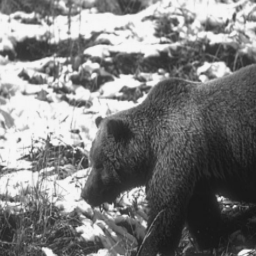

In [9]:
Image.fromarray(np.uint8(natural_scenes[1,:,:,:]*255))